# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [30]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

# Loading data from the Bitcoin API

In [31]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-23,7876.50,7971.26,7478.74,7626.89,50121.07,3.867663e+08,7738.3475
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8899.52,8931.53,8680.66,8726.23,40820.22,3.590994e+08,8809.4850


In [32]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()

time
2019-01-01    3702.983387
2019-02-01    3685.287679
2019-03-01    3942.984919
2019-04-01    5151.814333
2019-05-01    7056.672963
Freq: MS, Name: Weighted_Price, dtype: float64

In [37]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


# Bitcoin graph

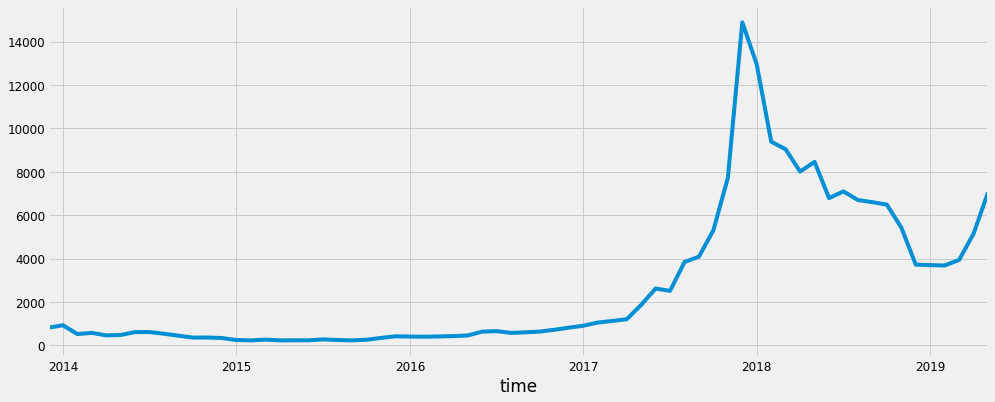

In [33]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

# ARIMA prediction
Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

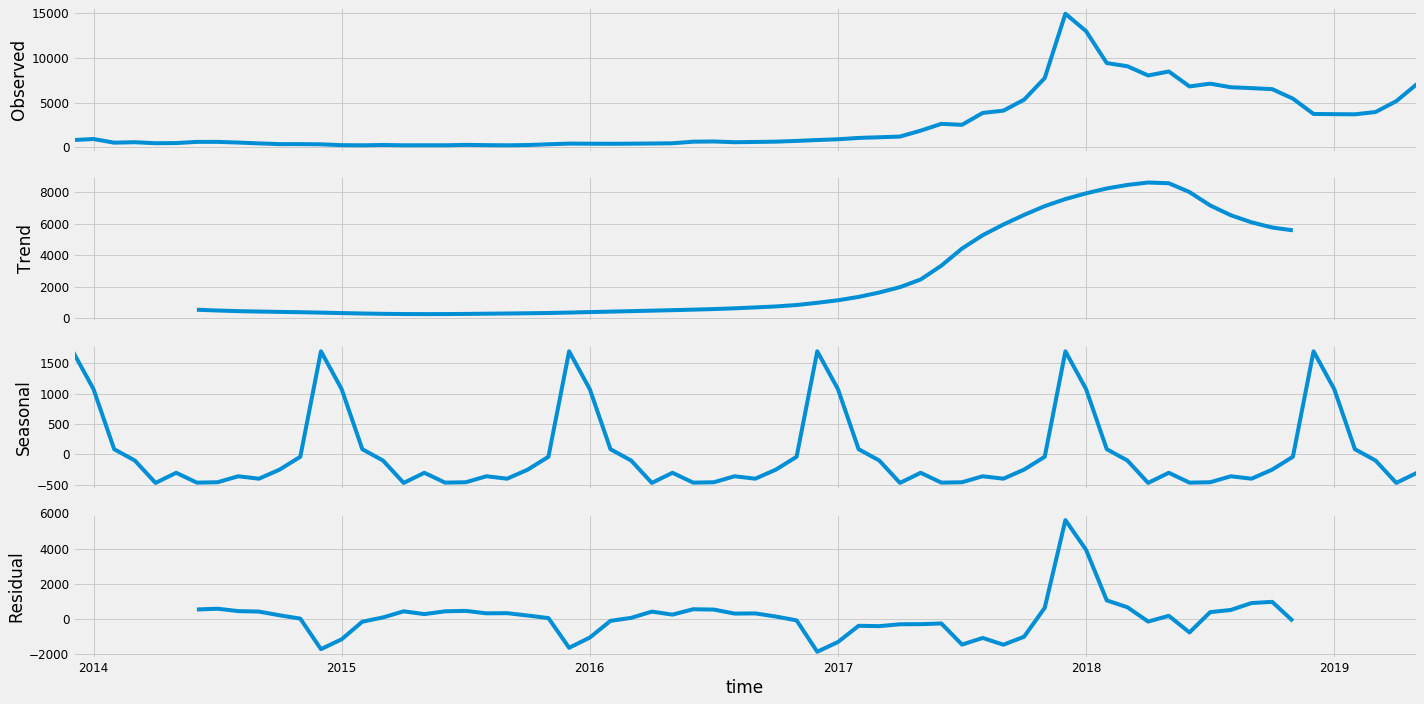

In [49]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual might be noise?
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [65]:
# ARIMA model
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 2)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [73]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1275.8087314436593
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1038.4147381148844
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1040.8915177178385
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:811.8354963588367
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1054.8980868754284
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1026.523709921229
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:830.3062051411765
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:806.6144820623728
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1185.3469783148303
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:967.3334842075965
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:973.7167716453885
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:753.3354836936335
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1001.1526704160203
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:966.8328588090045
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:788.0550701103676
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:750.2925309637333
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1090.9829096562432
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:897.689276676353
ARIM

In [86]:
model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2196      0.087      2.533      0.011       0.050       0.389
ar.S.L12      -1.8794      0.481     -3.908      0.000      -2.822      -0.937
ma.S.L12       1.1672      0.103     11.278      0.000       0.964       1.370
sigma2        1.3e+06    1.1e-07   1.19e+13      0.000     1.3e+06     1.3e+06


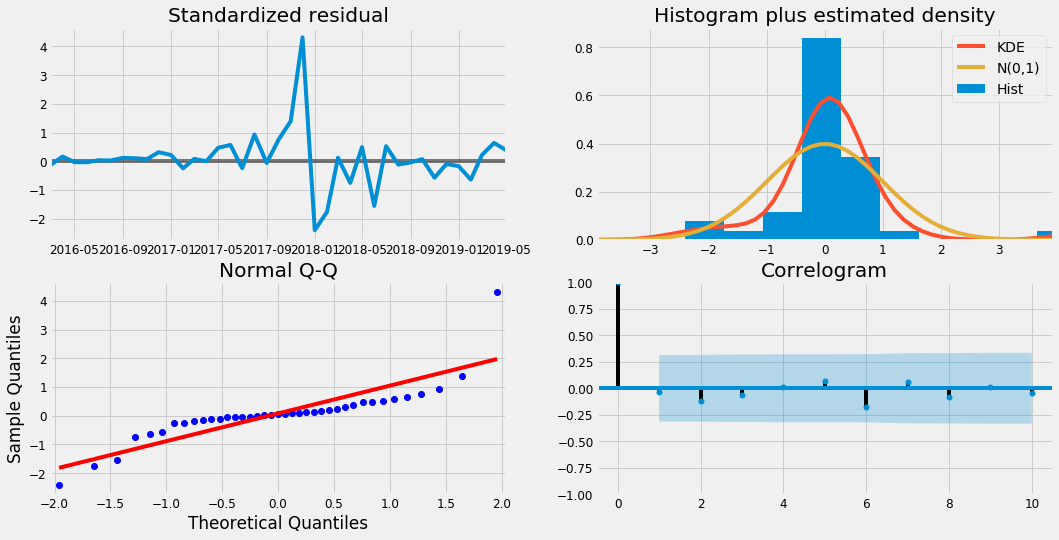

In [83]:
# Plitting model diagnostics to investigate unusual behavior.
# Residual is the difference between true and predicted value.

# Normal Quantile-Quantile is a way to visualize if the data were normally distributes. The closer to the line, the more normally distributed.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

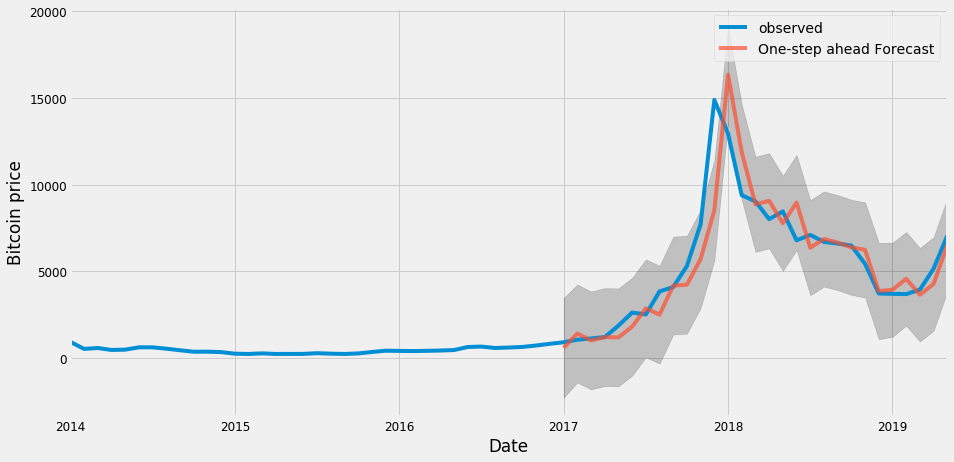

In [89]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = month_hist['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()

plt.show()

In [90]:
print(pred)
print('---------')
print(pred_ci)

---------
            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2291.387949           3466.037363
2017-02-01          -1411.800895           4238.517404
2017-03-01          -1811.179334           3838.424264
2017-04-01          -1616.812407           4032.761897
2017-05-01          -1634.734641           4014.838260
2017-06-01          -1020.123786           4629.449047
2017-07-01             41.703392           5691.276222
2017-08-01           -324.766235           5324.806594
2017-09-01           1354.547660           7004.120488
2017-10-01           1406.688441           7056.268309
2017-11-01           2883.413763           8537.314598
2017-12-01           5634.053179          11416.335187
2018-01-01          13571.440369          19117.970688
2018-02-01           9125.349399          14616.133202
2018-03-01           6121.433429          11611.919897
2018-04-01           6324.149261          11814.622729


In [112]:
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

mse = mean_squared_error(y_truth, y_forecasted)
print(f'Mean squared error:',mse)

Mean squared error: 2633576.046708956


In [118]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_truth, y_forecasted)
print(mae)

977.0139207576806


In [115]:
rmse = sqrt(mse)
print(f'Root mean squared error:',rmse)

Root mean squared error: 1622.8296419245478


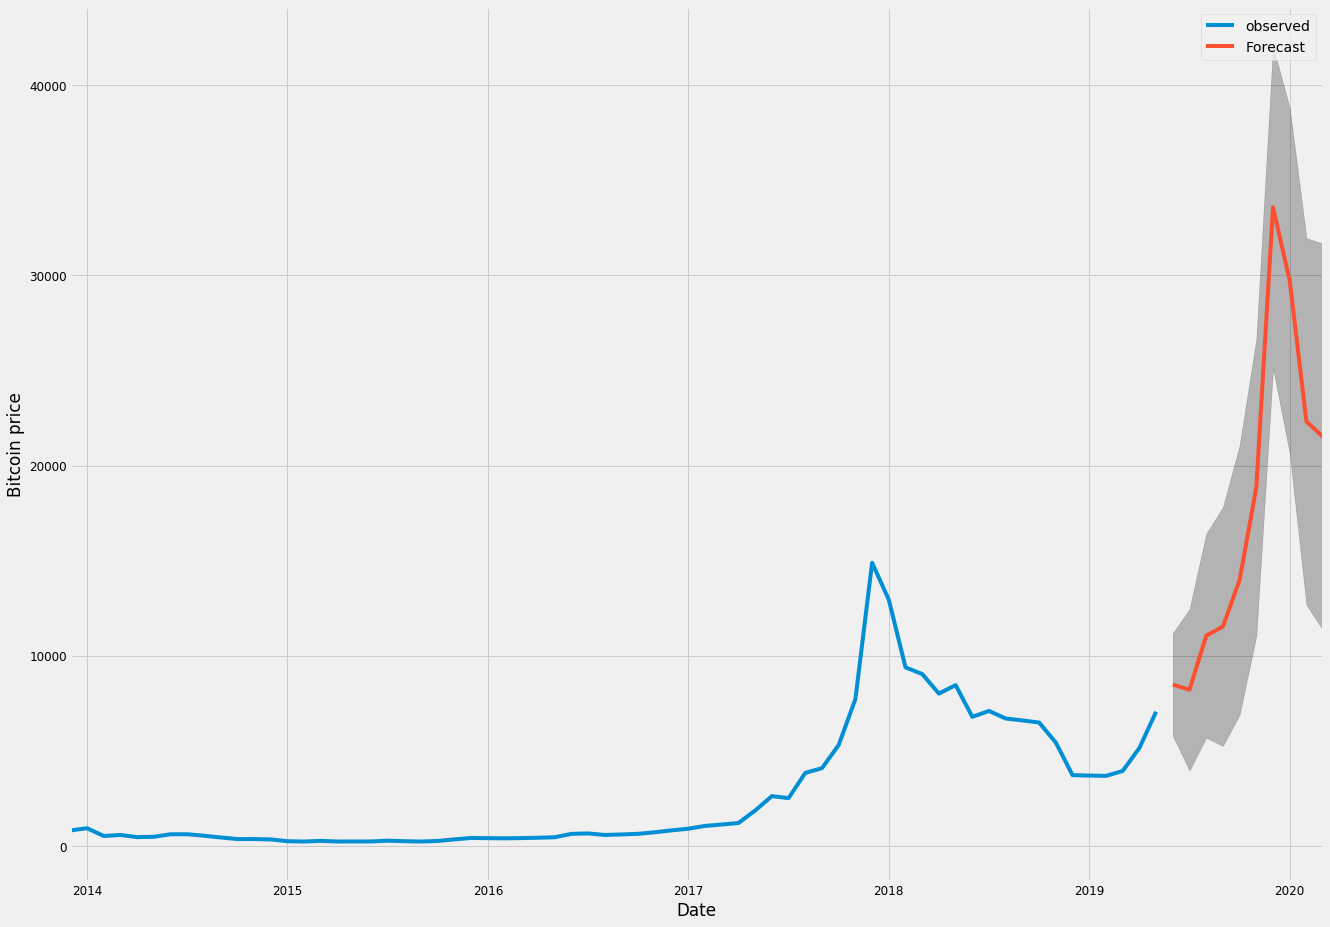

In [94]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()

ax = month_hist.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')

plt.legend()
plt.show()

# RNN LSTM Prediction

In [120]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
values = values.astype('float32')
print(values[0])
# Transform values to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the type of the new item scaled
print(type(scaled))

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1190.865]
[1190.865]
<class 'numpy.ndarray'>
Length of the new datframe : 2001
[[0.05601164]
 [0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]]


In [121]:
scaled

array([[0.05601164],
       [0.05196624],
       [0.04434619],
       ...,
       [0.4136669 ],
       [0.43082842],
       [0.4540662 ]], dtype=float32)

In [122]:
# Divide data scaled data into 80% train and 40% test with overlapping
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))
test_size = int(len(scaled) * 0.4)
print("Test Size : " + str(test_size))
overlap = int(len(scaled) * 0.6)
train, test = scaled[:train_size,:], scaled[overlap:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 800
Length of training data : 1600
Length of testing data : 801


In [123]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        print('X: ', a, ', Y: ', dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [124]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

X:  [0.05601164] , Y:  0.051966235
X:  [0.05196624] , Y:  0.044346187
X:  [0.04434619] , Y:  0.03316076
X:  [0.03316076] , Y:  0.03275506
X:  [0.03275506] , Y:  0.03938658
X:  [0.03938658] , Y:  0.045155503
X:  [0.0451555] , Y:  0.044295244
X:  [0.04429524] , Y:  0.040819865
X:  [0.04081986] , Y:  0.04223512
X:  [0.04223512] , Y:  0.041712645
X:  [0.04171265] , Y:  0.04074541
X:  [0.04074541] , Y:  0.037141245
X:  [0.03714124] , Y:  0.03211189
X:  [0.03211189] , Y:  0.025503486
X:  [0.02550349] , Y:  0.026986405
X:  [0.02698641] , Y:  0.030071884
X:  [0.03007188] , Y:  0.02762787
X:  [0.02762787] , Y:  0.027685214
X:  [0.02768521] , Y:  0.029172048
X:  [0.02917205] , Y:  0.030520689
X:  [0.03052069] , Y:  0.030285183
X:  [0.03028518] , Y:  0.033579264
X:  [0.03357926] , Y:  0.035716973
X:  [0.03571697] , Y:  0.034108795
X:  [0.0341088] , Y:  0.03409926
X:  [0.03409926] , Y:  0.035453778
X:  [0.03545378] , Y:  0.035611697
X:  [0.0356117] , Y:  0.03588743
X:  [0.03588743] , Y:  0.0378042

X:  [0.00572072] , Y:  0.0052135256
X:  [0.00521353] , Y:  0.0049564675
X:  [0.00495647] , Y:  0.005481687
X:  [0.00548169] , Y:  0.005523223
X:  [0.00552322] , Y:  0.0056622024
X:  [0.0056622] , Y:  0.0058032707
X:  [0.00580327] , Y:  0.0057390057
X:  [0.00573901] , Y:  0.0057285563
X:  [0.00572856] , Y:  0.0057285563
X:  [0.00572856] , Y:  0.005703869
X:  [0.00570387] , Y:  0.0056756553
X:  [0.00567566] , Y:  0.005720719
X:  [0.00572072] , Y:  0.0059109
X:  [0.0059109] , Y:  0.0062255613
X:  [0.00622556] , Y:  0.006325877
X:  [0.00632588] , Y:  0.006441344
X:  [0.00644134] , Y:  0.0063505634
X:  [0.00635056] , Y:  0.00620623
X:  [0.00620623] , Y:  0.0062839477
X:  [0.00628395] , Y:  0.0061893803
X:  [0.00618938] , Y:  0.0059423796
X:  [0.00594238] , Y:  0.0057917763
X:  [0.00579178] , Y:  0.005943293
X:  [0.00594329] , Y:  0.005731299
X:  [0.0057313] , Y:  0.0058667515
X:  [0.00586675] , Y:  0.0059419875
X:  [0.00594199] , Y:  0.0058986223
X:  [0.00589862] , Y:  0.005871453
X:  [0.00

X:  [0.05114269] , Y:  0.055293754
X:  [0.05529375] , Y:  0.05579128
X:  [0.05579128] , Y:  0.0565558
X:  [0.0565558] , Y:  0.05692754
X:  [0.05692754] , Y:  0.05793357
X:  [0.05793357] , Y:  0.058843456
X:  [0.05884346] , Y:  0.05862166
X:  [0.05862166] , Y:  0.058700554
X:  [0.05870055] , Y:  0.05895161
X:  [0.05895161] , Y:  0.059484273
X:  [0.05948427] , Y:  0.060709745
X:  [0.06070974] , Y:  0.062388062
X:  [0.06238806] , Y:  0.063102156
X:  [0.06310216] , Y:  0.06332996
X:  [0.06332996] , Y:  0.06376165
X:  [0.06376165] , Y:  0.06640525
X:  [0.06640525] , Y:  0.06860657
X:  [0.06860657] , Y:  0.07022899
X:  [0.07022899] , Y:  0.07280662
X:  [0.07280662] , Y:  0.07343869
X:  [0.07343869] , Y:  0.07369679
X:  [0.07369679] , Y:  0.07435511
X:  [0.07435511] , Y:  0.07790325
X:  [0.07790325] , Y:  0.08182025
X:  [0.08182025] , Y:  0.08367047
X:  [0.08367047] , Y:  0.0875488
X:  [0.0875488] , Y:  0.08482501
X:  [0.08482501] , Y:  0.08281152
X:  [0.08281152] , Y:  0.08620696
X:  [0.0862

X:  [0.7700592] , Y:  0.8065411
X:  [0.8065411] , Y:  0.76165664
X:  [0.76165664] , Y:  0.7494475
X:  [0.7494475] , Y:  0.6906076
X:  [0.6906076] , Y:  0.6858638
X:  [0.6858638] , Y:  0.70036954
X:  [0.70036954] , Y:  0.7309962
X:  [0.7309962] , Y:  0.77653164
X:  [0.77653164] , Y:  0.77737373
X:  [0.77737373] , Y:  0.83098334
X:  [0.83098334] , Y:  0.87764436
X:  [0.87764436] , Y:  0.8608223
X:  [0.8608223] , Y:  0.7959185
X:  [0.7959185] , Y:  0.7651818
X:  [0.7651818] , Y:  0.7482158
X:  [0.7482158] , Y:  0.72570646
X:  [0.72570646] , Y:  0.7008354
X:  [0.7008354] , Y:  0.7319148
X:  [0.7319148] , Y:  0.7165109
X:  [0.7165109] , Y:  0.7127597
X:  [0.7127597] , Y:  0.628582
X:  [0.628582] , Y:  0.5605067
X:  [0.5605067] , Y:  0.5815639
X:  [0.5815639] , Y:  0.5860829
X:  [0.5860829] , Y:  0.63172066
X:  [0.63172066] , Y:  0.6236698
X:  [0.6236698] , Y:  0.5730347
X:  [0.5730347] , Y:  0.555999
X:  [0.555999] , Y:  0.57270753
X:  [0.57270753] , Y:  0.5851854
X:  [0.5851854] , Y:  0.57

X:  [0.26415312] , Y:  0.25733244
X:  [0.25733244] , Y:  0.2595663
X:  [0.2595663] , Y:  0.261094
X:  [0.261094] , Y:  0.25982976
X:  [0.25982976] , Y:  0.2617079
X:  [0.2617079] , Y:  0.26692447
X:  [0.26692447] , Y:  0.26909456
X:  [0.26909456] , Y:  0.27005708
X:  [0.27005708] , Y:  0.2715238
X:  [0.2715238] , Y:  0.27087748
X:  [0.27087748] , Y:  0.2734588
X:  [0.2734588] , Y:  0.28026417
X:  [0.28026417] , Y:  0.28138423
X:  [0.28138423] , Y:  0.27031937
X:  [0.27031937] , Y:  0.26630062
X:  [0.26630062] , Y:  0.26729476
X:  [0.26729476] , Y:  0.2685885
X:  [0.2685885] , Y:  0.26773548
X:  [0.26773548] , Y:  0.27051425
X:  [0.27051425] , Y:  0.27467552
X:  [0.27467552] , Y:  0.2786548
X:  [0.2786548] , Y:  0.28939274
X:  [0.28939274] , Y:  0.29540372
X:  [0.29540372] , Y:  0.2967424
X:  [0.2967424] , Y:  0.2943478
X:  [0.2943478] , Y:  0.2987538
X:  [0.2987538] , Y:  0.30209973
X:  [0.30209973] , Y:  0.31190428
X:  [0.31190428] , Y:  0.3217503
X:  [0.3217503] , Y:  0.35040262
X:  

In [125]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [126]:
print(trainX)
#print(trainY)

[[[0.05601164]]

 [[0.05196624]]

 [[0.04434619]]

 ...

 [[0.41526136]]

 [[0.42417052]]

 [[0.442697  ]]]


In [127]:
# Initialise the sequential model
model = Sequential()
# Add the LSTM hidden layer with 100 nodes
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dropout(0.2))
# Add the output layer
model.add(Dense(1))
# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')
# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 2s 1ms/step - loss: 0.0807 - val_loss: 0.2686
Epoch 2/300
1599/1599 [==============================] - 0s 72us/step - loss: 0.0793 - val_loss: 0.2605
Epoch 3/300
1599/1599 [==============================] - 0s 56us/step - loss: 0.0761 - val_loss: 0.2554
Epoch 4/300
1599/1599 [==============================] - 0s 50us/step - loss: 0.0715 - val_loss: 0.2411
Epoch 5/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0697 - val_loss: 0.2311
Epoch 6/300
1599/1599 [==============================] - 0s 53us/step - loss: 0.0664 - val_loss: 0.2208
Epoch 7/300
1599/1599 [==============================] - 0s 53us/step - loss: 0.0628 - val_loss

1599/1599 [==============================] - 0s 47us/step - loss: 0.0062 - val_loss: 0.0090
Epoch 70/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0062 - val_loss: 0.0085
Epoch 71/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0054 - val_loss: 0.0091
Epoch 72/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0078 - val_loss: 0.0107
Epoch 73/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0081 - val_loss: 0.0092
Epoch 74/300
1599/1599 [==============================] - 0s 53us/step - loss: 0.0080 - val_loss: 0.0090
Epoch 75/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0088 - val_loss: 0.0086
Epoch 76/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0065 - val_loss: 0.0093
Epoch 77/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0071 - val_loss: 0.0092
Epoch 78/300
1599/1599 [==============================] - 0s 47us/st

1599/1599 [==============================] - 0s 50us/step - loss: 0.0054 - val_loss: 0.0091
Epoch 147/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0050 - val_loss: 0.0085
Epoch 148/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0058 - val_loss: 0.0083
Epoch 149/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 150/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0058 - val_loss: 0.0086
Epoch 151/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0050 - val_loss: 0.0084
Epoch 152/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0050 - val_loss: 0.0085
Epoch 153/300
1599/1599 [==============================] - 0s 53us/step - loss: 0.0056 - val_loss: 0.0086
Epoch 154/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0047 - val_loss: 0.0084
Epoch 155/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 45us/step - loss: 0.0058 - val_loss: 0.0089
Epoch 224/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0064 - val_loss: 0.0086
Epoch 225/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0053 - val_loss: 0.0089
Epoch 226/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0059 - val_loss: 0.0091
Epoch 227/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0057 - val_loss: 0.0091
Epoch 228/300
1599/1599 [==============================] - 0s 52us/step - loss: 0.0052 - val_loss: 0.0085
Epoch 229/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0049 - val_loss: 0.0084
Epoch 230/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0055 - val_loss: 0.0098
Epoch 231/300
1599/1599 [==============================] - 0s 54us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 232/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 47us/step - loss: 0.0049 - val_loss: 0.0092


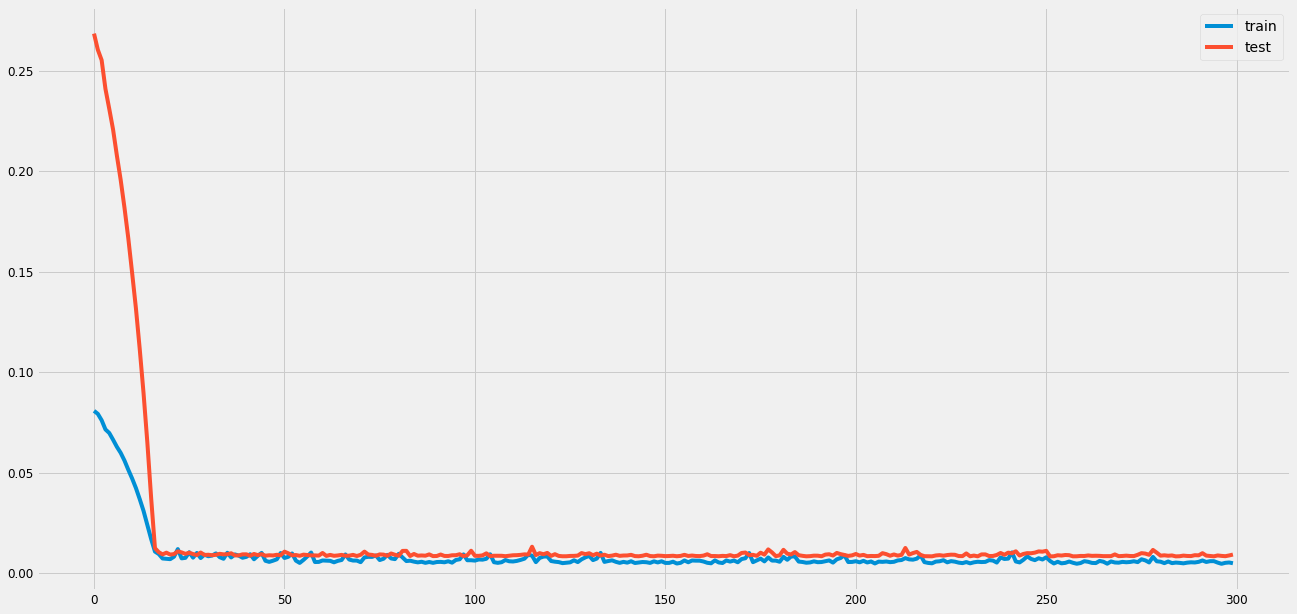

In [131]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(800, 1)
[0.05242324]


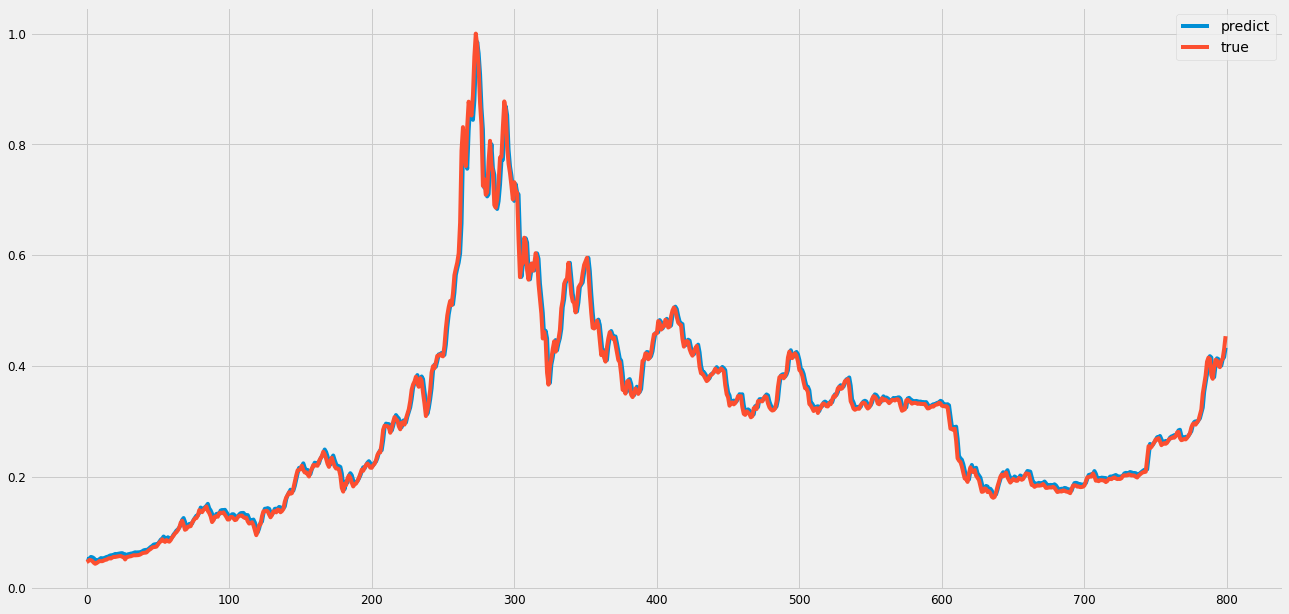

In [133]:
yhat = model.predict(testX) # Here yhat is the predicted value from the test set (y_pred)
print(yhat.shape)
print(yhat[0])

plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [134]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1122.1843]
[1006.24]


In [135]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 290.082


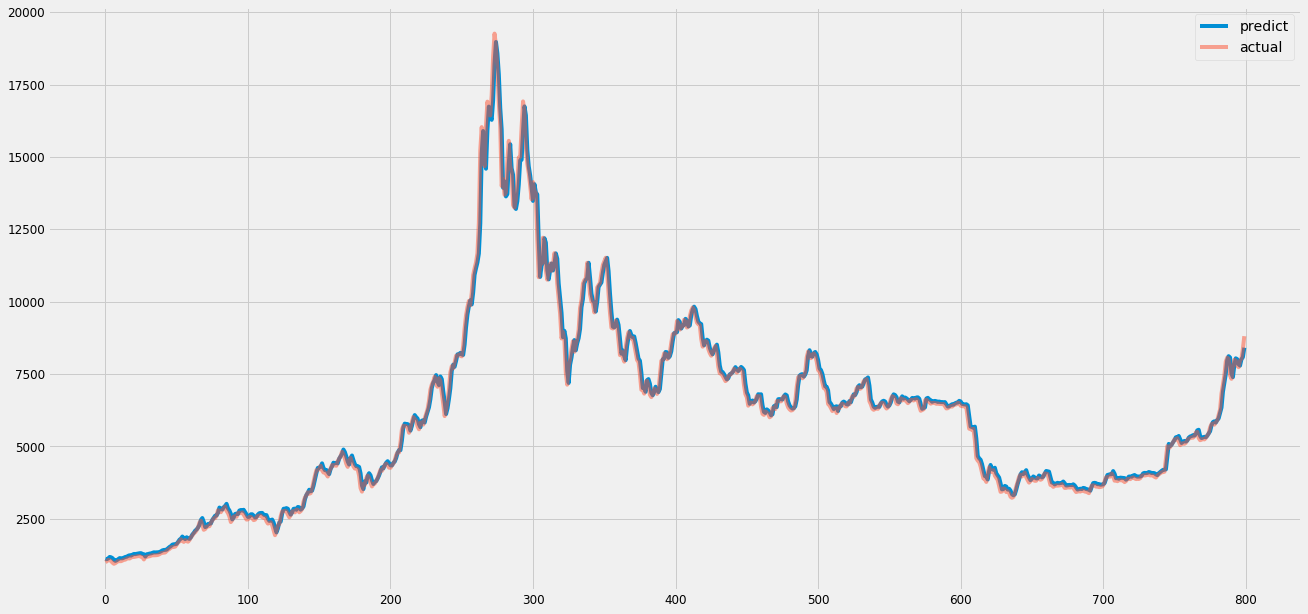

In [137]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [138]:
Xtest = testX

In [139]:
x = np.zeros((1,1,1))
x[[0]] = yhat[len(yhat)-1][0]
preds = []
#model.reset_states()
for i in range(120):
    yklat = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    #print(yklat)
    preds.append(yklat[0][0])
    #print('X: ', x, ', Y: ', yklat)
    #print(yklat[len(yklat)-1][0])
    y = np.zeros((1,1,1))
    y[[0]] = yklat[len(yklat)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)
    #x[[0]] = yklat[0][0]
    
    #model.reset_states()
    
print(yklat.shape)
print(yklat[0])
print(yklat)

(919, 1)
[0.05242324]
[[0.05242324]
 [0.05161989]
 [0.0530172 ]
 [0.05568395]
 [0.05500239]
 [0.05343107]
 [0.05052362]
 [0.04860264]
 [0.04982629]
 [0.0516234 ]
 [0.05354602]
 [0.05328523]
 [0.05328627]
 [0.05441504]
 [0.05566111]
 [0.05606034]
 [0.05776227]
 [0.05872618]
 [0.05811466]
 [0.05973775]
 [0.06107385]
 [0.06084729]
 [0.06134128]
 [0.06194491]
 [0.06236079]
 [0.0625335 ]
 [0.06112679]
 [0.06052225]
 [0.05636512]
 [0.06048864]
 [0.06098288]
 [0.06174236]
 [0.06211165]
 [0.06311107]
 [0.06401498]
 [0.06379464]
 [0.06387302]
 [0.06412243]
 [0.0646516 ]
 [0.06586906]
 [0.06753644]
 [0.06824588]
 [0.06847221]
 [0.0689011 ]
 [0.07152759]
 [0.07371473]
 [0.07532673]
 [0.07788789]
 [0.07851593]
 [0.0787724 ]
 [0.07942653]
 [0.08295218]
 [0.08684452]
 [0.08868314]
 [0.09253729]
 [0.08983047]
 [0.08782957]
 [0.0912038 ]
 [0.08912382]
 [0.08821002]
 [0.09123326]
 [0.09612003]
 [0.09915857]
 [0.10314473]
 [0.10527832]
 [0.10881717]
 [0.11351821]
 [0.12239952]
 [0.12586114]
 [0.11904579

In [140]:
yklat

array([[0.05242324],
       [0.05161989],
       [0.0530172 ],
       [0.05568395],
       [0.05500239],
       [0.05343107],
       [0.05052362],
       [0.04860264],
       [0.04982629],
       [0.0516234 ],
       [0.05354602],
       [0.05328523],
       [0.05328627],
       [0.05441504],
       [0.05566111],
       [0.05606034],
       [0.05776227],
       [0.05872618],
       [0.05811466],
       [0.05973775],
       [0.06107385],
       [0.06084729],
       [0.06134128],
       [0.06194491],
       [0.06236079],
       [0.0625335 ],
       [0.06112679],
       [0.06052225],
       [0.05636512],
       [0.06048864],
       [0.06098288],
       [0.06174236],
       [0.06211165],
       [0.06311107],
       [0.06401498],
       [0.06379464],
       [0.06387302],
       [0.06412243],
       [0.0646516 ],
       [0.06586906],
       [0.06753644],
       [0.06824588],
       [0.06847221],
       [0.0689011 ],
       [0.07152759],
       [0.07371473],
       [0.07532673],
       [0.077

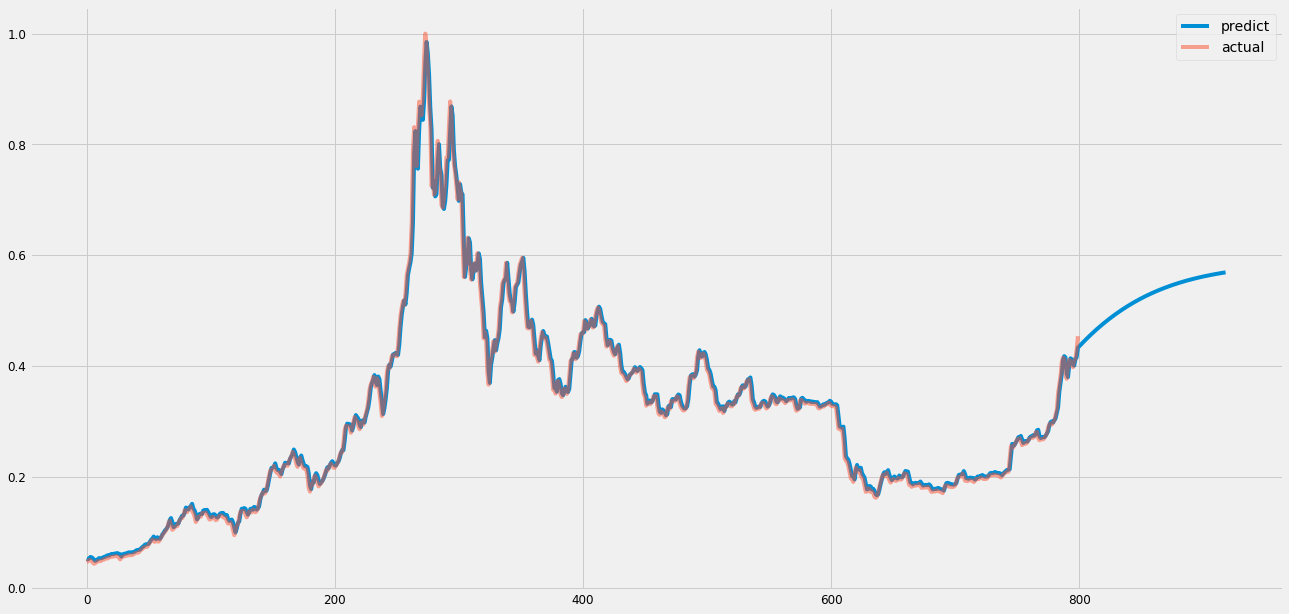

In [142]:
plt.plot(yklat, label='predict')
plt.plot(testY, label='actual', alpha=0.5)
plt.legend()
plt.show()